In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats

%matplotlib inline

# Loan Default Rate Analysis
By Cong Feng

## Project Context

This project will analyze the peer-to-peer lending platform Prosper's data to understand which borrower feature makes them more likely to default. To achieve this goal, I will be first cleaning the data; then performing exploratory data analysis. Lastly, I will use the XGBoost machine learning model to train and predict a borrower's default status.

[Data Dictionary](https://rstudio-pubs-static.s3.amazonaws.com/86324_ab1e2e2fa210452f80a1c6a1476d7a2a.html)

The data dictionary shows 81 features for this dataset; due to both time and hardware constraints, I will only use a portion of the total for this analysis. In this analysis, the features I will use are loan amount, borrower's credit rating, loan APR, debt to income ratio, loan term, income verifiable, open credit lines, monthly income, and loan status. In my experience, these are the most crucial features when determining a borrower's ability to maintain the loan.

 - Term: length of loan in months.
 - LoanOriginalAmount: Loan origination amount in USD.
 - CreditGrade: borrower's credit score .
 - BorrowerAPR: Annual percentage rate charged for the loan.
 - DebtToIncomeRatio: All of borrower's obligations to their monthly income.
 - IncomeVerifiable: If the borrower can prove their stated income.
 - OpenCreditLines: Total number of credit lines a borrower has opened.
 - StatedMonthlyIncome: The monthly income borrower stated on loan application.
 
## Data Loading and Cleaning

In [2]:
prosper_df = pd.read_csv('prosperLoanData.csv')

In [3]:
print(prosper_df.shape)
print(prosper_df.head())

(113937, 81)
                ListingKey  ListingNumber            ListingCreationDate  \
0  1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1  10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2  0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3  0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   
4  0F023589499656230C5E3E2         909464  2013-09-14 18:38:39.097000000   

  CreditGrade  Term LoanStatus           ClosedDate  BorrowerAPR  \
0           C    36  Completed  2009-08-14 00:00:00      0.16516   
1         NaN    36    Current                  NaN      0.12016   
2          HR    36  Completed  2009-12-17 00:00:00      0.28269   
3         NaN    36    Current                  NaN      0.12528   
4         NaN    36    Current                  NaN      0.24614   

   BorrowerRate  LenderYield  ...  LP_ServiceFees  LP_CollectionFees  \
0        0.1580       0.1380  ...         -133.18

In [4]:
features = ['CreditGrade', 'Term', 'BorrowerAPR', 'LoanStatus', 'DebtToIncomeRatio', 'IncomeVerifiable', 'LoanOriginalAmount', 'StatedMonthlyIncome', 'OpenCreditLines']

df = prosper_df[features].copy()

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CreditGrade          28953 non-null   object 
 1   Term                 113937 non-null  int64  
 2   BorrowerAPR          113912 non-null  float64
 3   LoanStatus           113937 non-null  object 
 4   DebtToIncomeRatio    105383 non-null  float64
 5   IncomeVerifiable     113937 non-null  bool   
 6   LoanOriginalAmount   113937 non-null  int64  
 7   StatedMonthlyIncome  113937 non-null  float64
 8   OpenCreditLines      106333 non-null  float64
dtypes: bool(1), float64(4), int64(2), object(2)
memory usage: 7.1+ MB
None


In [6]:
print(prosper_df[(prosper_df['CreditGrade'].isnull()) & (prosper_df['ProsperRating (Alpha)'].isnull())].shape)

(131, 81)


In [7]:
prosper_df['CreditGrade'].value_counts()

C     5649
D     5153
B     4389
AA    3509
HR    3508
A     3315
E     3289
NC     141
Name: CreditGrade, dtype: int64

In [8]:
prosper_df['ProsperRating (Alpha)'].value_counts()

C     18345
B     15581
A     14551
D     14274
E      9795
HR     6935
AA     5372
Name: ProsperRating (Alpha), dtype: int64

In [9]:
df['ProsperRating (Alpha)'] = prosper_df['ProsperRating (Alpha)']
df.loc[df['CreditGrade'].notnull(),'ProsperRating (Alpha)'] = prosper_df.loc[prosper_df['CreditGrade'].notnull(), 'CreditGrade']

In [10]:
print(df['ProsperRating (Alpha)'].isnull().sum())
df.drop(columns='CreditGrade', inplace=True)

131


The info method shows there are only around 28000 non-null values in the credit grade feature. However, the ProsperRating Alpha column has roughly the remaining non-null values. When combined, there are only 131 null rows. These two columns also appear to be on the same scale; I will combine the two columns. This method leaves only 131 null values in the ProsperRating.

<AxesSubplot:>

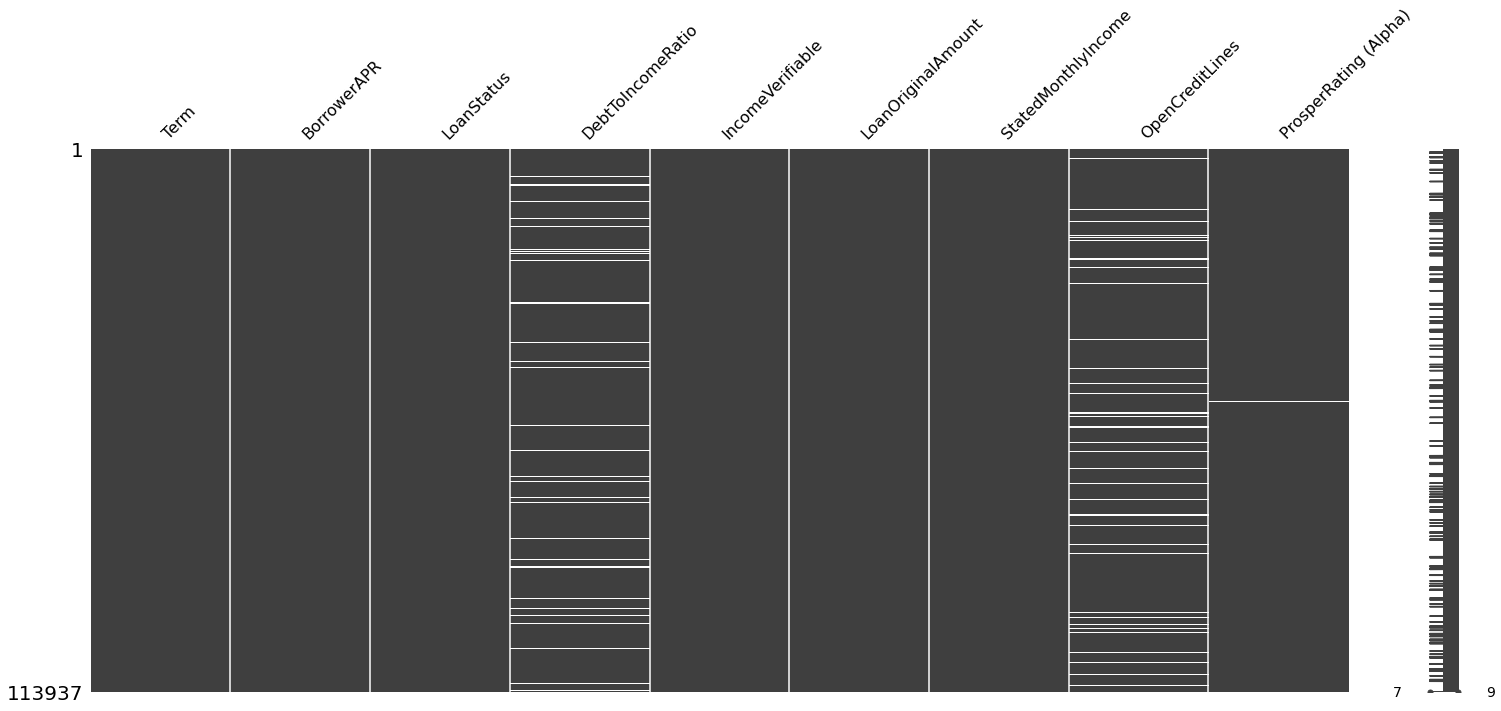

In [11]:
msno.matrix(df)

In [12]:
print(df.isna().sum())

Term                        0
BorrowerAPR                25
LoanStatus                  0
DebtToIncomeRatio        8554
IncomeVerifiable            0
LoanOriginalAmount          0
StatedMonthlyIncome         0
OpenCreditLines          7604
ProsperRating (Alpha)     131
dtype: int64


In [13]:
df.describe()

,Term,BorrowerAPR,DebtToIncomeRatio,LoanOriginalAmount,StatedMonthlyIncome,OpenCreditLines
count,113937.000000,113912.000000,105383.000000,113937.00000,1.139370e+05,106333.000000
mean,40.830248,0.218828,0.275947,8337.01385,5.608026e+03,9.260164
std,10.436212,0.080364,0.551759,6245.80058,7.478497e+03,5.022644
min,12.000000,0.006530,0.000000,1000.00000,0.000000e+00,0.000000
25%,36.000000,0.156290,0.140000,4000.00000,3.200333e+03,6.000000
50%,36.000000,0.209760,0.220000,6500.00000,4.666667e+03,9.000000
75%,36.000000,0.283810,0.320000,12000.00000,6.825000e+03,12.000000
max,60.000000,0.512290,10.010000,35000.00000,1.750003e+06,54.000000


The msno matrix shows 'DebtToIncomeRatio'(DTI) and 'OpenCreditLines' has the most missing values. The DTI column also has significant outliers; the max value is 10.01, which translates to a borrower having ten dollars of obligation per dollar of income. 

In [14]:
print((df['DebtToIncomeRatio'] > 1).sum())

799


In [15]:
df.drop(index=df[df['DebtToIncomeRatio'] > 1].index, inplace=True)

In [16]:
print(df['DebtToIncomeRatio'].isna().sum())

8554


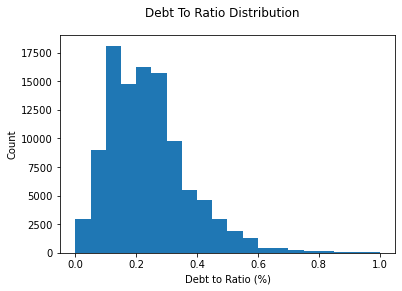

In [17]:
plt.hist(df['DebtToIncomeRatio'], bins=20)
plt.suptitle('Debt To Ratio Distribution')
plt.xlabel('Debt to Ratio (%)')
plt.ylabel('Count')
plt.show()

In [18]:
df['DebtToIncomeRatio'].fillna(df['DebtToIncomeRatio'].median(), inplace=True)
print(df['DebtToIncomeRatio'].isna().sum())

0


There were 799 cases where the debt to income was greater than one. These figures are unrealistic and are outliers; therefore, I removed them from the data set. After removing the outliers, 8554 null values remained. Next, I visualized the distribution of this feature with a histogram; it was right-skewed. Therefore,  the median is a good estimator for this distribution, and I used these metrics to fill the null values. It is tempting to calculate this metric by dividing the monthly loan payment by the borrower's income; however, this ratio includes all of the borrower's obligations, even outside of Prosper.

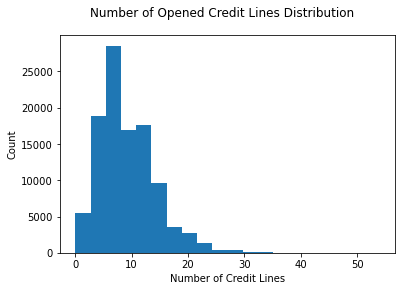

In [19]:
plt.hist(df['OpenCreditLines'], bins=20)
plt.suptitle('Number of Opened Credit Lines Distribution')
plt.xlabel('Number of Credit Lines')
plt.ylabel('Count')
plt.show()

In [20]:
df['OpenCreditLines'].fillna(df['OpenCreditLines'].median(), inplace=True)
print(df['OpenCreditLines'].isna().sum())

0


The distribution for the number of opened lines is right-skewed as well. Therefore, I will fill the nulls with the same method as the DTI ratio feature.

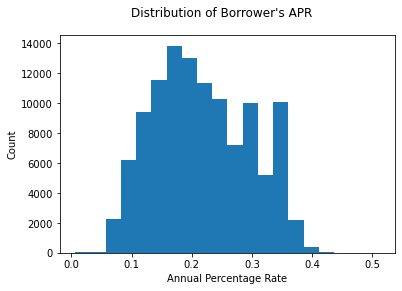

In [21]:
plt.hist(df['BorrowerAPR'], bins=20)
plt.suptitle("Distribution of Borrower's APR")
plt.xlabel('Annual Percentage Rate')
plt.ylabel('Count')
plt.show()

In [22]:
df['BorrowerAPR'].fillna(df['BorrowerAPR'].mean(), inplace=True)
print(df['BorrowerAPR'].isna().sum())

0


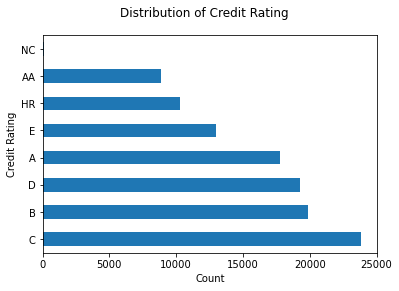

In [23]:
df['ProsperRating (Alpha)'].value_counts().plot(kind='barh')
plt.suptitle('Distribution of Credit Rating')
plt.xlabel('Count')
plt.ylabel('Credit Rating')
plt.show()

In [24]:
df['ProsperRating (Alpha)'].fillna('C',inplace=True)

<AxesSubplot:>

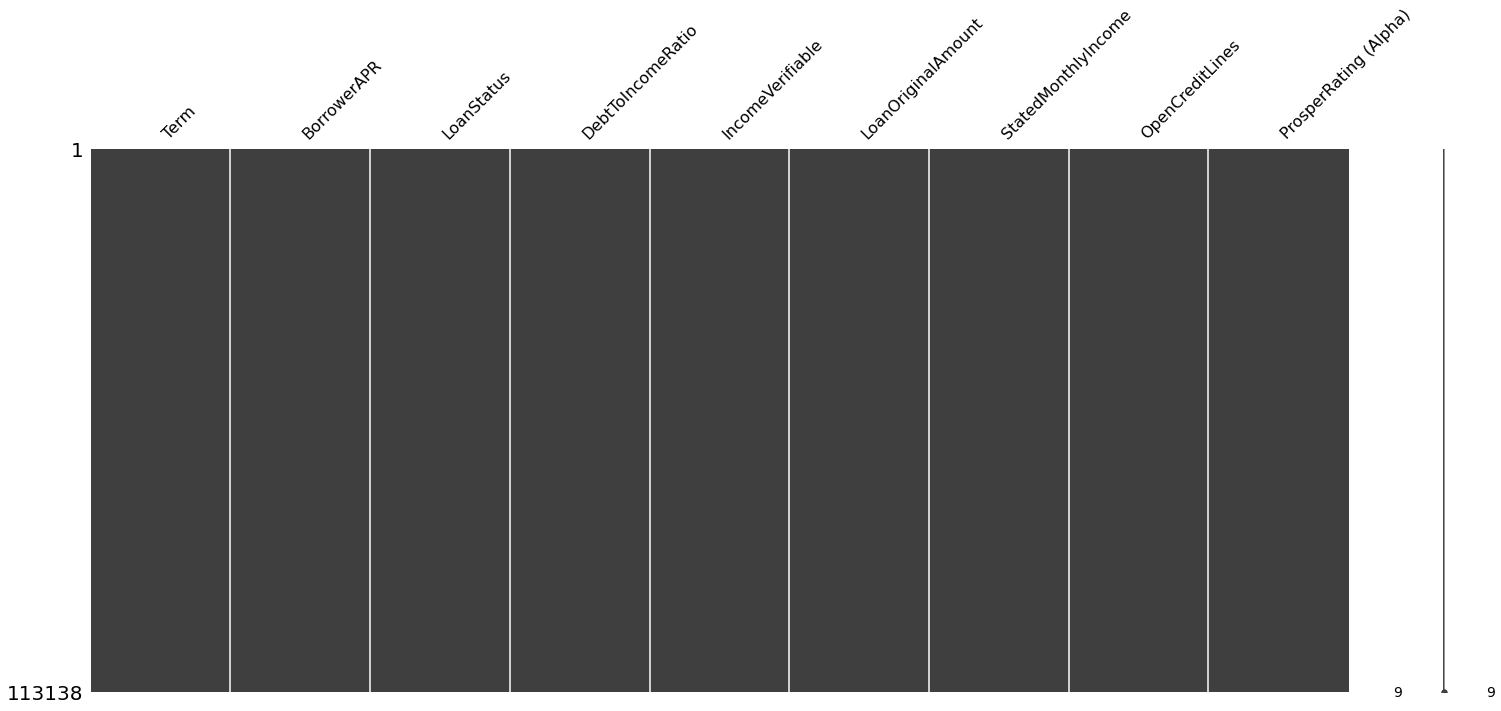

In [25]:
msno.matrix(df)

The borrower's APR ranges from 0.006 to 0.51, with the interquartile range between 0.17 to 0.28. The majority of the values fall between 0.1 and 0.4; the data doesn't skew in either direction. Therefore, I will fill the null values with the mean.

The Credit Rating column is filled with categorical values, with the majority of the borrowers at a C rating. Therefore, I will also fill the null values with the mode in this instance. There are no more null values in the chosen features.

In [26]:
df['StatedMonthlyIncome'].describe()

count    1.131380e+05
mean     5.641723e+03
std      7.493010e+03
min      0.000000e+00
25%      3.250000e+03
50%      4.666667e+03
75%      6.833333e+03
max      1.750003e+06
Name: StatedMonthlyIncome, dtype: float64

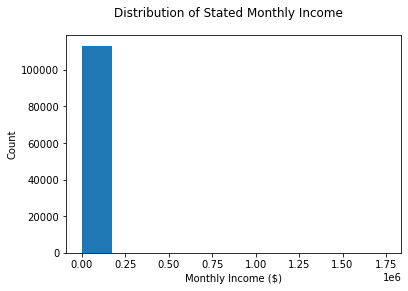

In [27]:
plt.hist(df['StatedMonthlyIncome'])
plt.suptitle('Distribution of Stated Monthly Income')
plt.ylabel('Count')
plt.xlabel('Monthly Income ($)')
plt.show()

In [28]:
df[df['StatedMonthlyIncome'] > 20000].shape

(1189, 9)

In [29]:
df.drop(index=df[df['StatedMonthlyIncome'] > 20000].index, inplace=True)

In [30]:
df['StatedMonthlyIncome'].describe()

count    111949.000000
mean       5345.666957
std        3113.074933
min           0.000000
25%        3241.666667
50%        4658.333333
75%        6666.666667
max       20000.000000
Name: StatedMonthlyIncome, dtype: float64

The stated monthly income variable has significant outliers; some borrowers reported over 20,000 USD monthly income. Even though these figures are plausible, they create outliers that skew the analysis and the model. Only about 1% of borrowers fall into this category. Therefore, I will remove them from the data.

In [31]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111949 entries, 0 to 113936
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Term                   111949 non-null  int64  
 1   BorrowerAPR            111949 non-null  float64
 2   LoanStatus             111949 non-null  object 
 3   DebtToIncomeRatio      111949 non-null  float64
 4   IncomeVerifiable       111949 non-null  bool   
 5   LoanOriginalAmount     111949 non-null  int64  
 6   StatedMonthlyIncome    111949 non-null  float64
 7   OpenCreditLines        111949 non-null  float64
 8   ProsperRating (Alpha)  111949 non-null  object 
dtypes: bool(1), float64(4), int64(2), object(2)
memory usage: 7.8+ MB
None


The stated monthly income variable had some 

In [32]:
df['OpenCreditLines'] = df['OpenCreditLines'].astype(int)
# remove (alpha) from column name
df.rename(columns={'ProsperRating (Alpha)':'ProsperRating'}, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111949 entries, 0 to 113936
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Term                 111949 non-null  int64  
 1   BorrowerAPR          111949 non-null  float64
 2   LoanStatus           111949 non-null  object 
 3   DebtToIncomeRatio    111949 non-null  float64
 4   IncomeVerifiable     111949 non-null  bool   
 5   LoanOriginalAmount   111949 non-null  int64  
 6   StatedMonthlyIncome  111949 non-null  float64
 7   OpenCreditLines      111949 non-null  int32  
 8   ProsperRating        111949 non-null  object 
dtypes: bool(1), float64(3), int32(1), int64(2), object(2)
memory usage: 7.4+ MB
None


In [33]:
df.shape

(111949, 9)

In [34]:
print(df.head())
df.to_csv('prosper_cleaned.csv')

   Term  BorrowerAPR LoanStatus  DebtToIncomeRatio  IncomeVerifiable  \
0    36      0.16516  Completed               0.17              True   
1    36      0.12016    Current               0.18              True   
2    36      0.28269  Completed               0.06              True   
3    36      0.12528    Current               0.15              True   
4    36      0.24614    Current               0.26              True   

   LoanOriginalAmount  StatedMonthlyIncome  OpenCreditLines ProsperRating  
0                9425          3083.333333                4             C  
1               10000          6125.000000               14             A  
2                3001          2083.333333                9            HR  
3               10000          2875.000000                5             A  
4               15000          9583.333333               19             D  


I removed the outliers from the DTI and InquiriesLast6Month features for the data cleaning step. Then, I filled the null values of each feature with the appropriate method depending on the distribution. Lastly, I updated OpenCreditLine's datatypes and removed the (Alpha) part of the ProsperRating column name. 

After performing these steps, the resulting data frame comprises 111843 rows with nine columns and no null values. There are six numerical columns, three of these are discrete; the remainders features consists of two categorical and one boolean values.  

## Exploratory Data Analysis

All statistical tests done will have $H_0$: no difference in the mean/proportion compared, $H_a$: there is a difference in the observations, and $\alpha$: 0.05.

#### Functions

In [35]:
#Plotting Functions

def plot_countplots(feature, group='binary_loan_status'):
    # for discrete/categorical variables
    base_color = sns.color_palette()[0]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    sns.countplot(x=feature, data=df, ax=ax1, color=base_color)
    sns.countplot(x=feature, data=df, hue=group,  ax=ax2, color=base_color)
    
    ax1.set(title='Distribution of {}'.format(feature))
    ax2.set(title='Distribution of {} - By Status'.format(feature))
    plt.show()

def ecdf(array):
    x = sorted(array)
    y = np.arange(1, len(array)+1) / len(array)
    return x, y

def plot_ecdf_kde(feature, group='binary_loan_status'):
    # for continous/numerical variables
    # group only takes binary variables
    
    temp_df0 = df[df[group] == df[group].unique()[0]]
    temp_df1 = df[df[group] == df[group].unique()[1]]
    
    x, y = ecdf(df[feature])
    x_1, y_1 = ecdf(temp_df1[feature])
    x_0, y_0 = ecdf(temp_df0[feature])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,6))
    ax1.plot(x, y, marker='.', linestyle='None', alpha=0.5)
    
    ax2.plot(x_1, y_1, color='red', marker='.', linestyle='None', alpha=0.2, label=df[group].unique()[1])
    ax2.plot(x_0, y_0, color='blue', marker='.', linestyle='None', alpha=0.2, label=df[group].unique()[0])

    temp_df1[feature].plot(kind='kde', ax=ax3, color='red', label=df[group].unique()[1])
    temp_df0[feature].plot(kind='kde', ax=ax3, color='blue', label=df[group].unique()[0])
    
    ax1.set(title='{} ECDF'.format(feature), xlabel=feature, ylabel='ECDF')
    ax1.grid()
    ax2.set(title='{} ECDF - By {}'.format(feature, group), ylabel='ECDF', xlabel=feature)
    ax2.grid()
    ax2.legend()
    ax3.set(title='{} Density Graph - By {}'.format(feature, group), xlabel=feature)
    ax3.legend()

    plt.show()

In [36]:
# Statistical Functions 
def stats_df(feature):
    temp_df = pd.DataFrame({'Percentage of Total Loans':df[feature].value_counts(normalize=True) * 100,
             'Percentage of Negative Loans':df.groupby(feature)['binary_loan_status'].mean() * 100,
             'Percentage of Overall Negative Loans': df.loc[df['binary_loan_status'] == 1, feature].value_counts(normalize=True) * 100})
    return temp_df

def diff_means(feature):
    return loan_status_1[feature].mean() - loan_status_0[feature].mean()

def t_test(feature):
    # calculates two sample t-test by featue entered
    return stats.ttest_ind(loan_status_1[feature], loan_status_0[feature])


def anova(feature, group='binary_loan_status'):
    # Multi-sample 
    temp_list = [df.loc[df[feature] == var, group] for var in df[feature].unique()]
    return stats.f_oneway(*temp_list)

#### Loan Status

In [37]:
df['LoanStatus'].value_counts(normalize=True) * 100

Current                   49.773558
Completed                 33.370553
Chargedoff                10.476199
Defaulted                  4.374313
Past Due (1-15 days)       0.712825
Past Due (31-60 days)      0.320682
Past Due (61-90 days)      0.271552
Past Due (91-120 days)     0.267979
Past Due (16-30 days)      0.232249
FinalPaymentInProgress     0.181333
Past Due (>120 days)       0.014292
Cancelled                  0.004466
Name: LoanStatus, dtype: float64

In [38]:
def map_loan_status_to_binary(loanstatus):
    if loanstatus in ('Current', 'Completed', 'FinalPaymentInProgress'):
        return 0
    else:
        return 1

In [39]:
df['binary_loan_status'] = df['LoanStatus'].apply(map_loan_status_to_binary)
# Create seperate df for each loan status
loan_status_1 = df[df['binary_loan_status'] == 1]
loan_status_0 = df[df['binary_loan_status'] == 0]

In [40]:
df['binary_loan_status'].value_counts(normalize=True) * 100

0    83.325443
1    16.674557
Name: binary_loan_status, dtype: float64

There are roughly 84% of the loans in good standing (completed, current, or making the final payment); the remainder is overdue, defaulted, or charged off. The default and charged-off statuses are similar. Default means there hasn't been a payment for an extended period. In comparison, a charged-off means no longer a reasonable expectation for the borrower to pay. Since this analysis aims to find the factors that result in a negative status for a loan, I will convert these samples to binary variables—a zero for good-status variables and one for all others.

#### Credit Rating

In [41]:
# Order the rating from worst to best
credit_rating_order = {'ProsperRating':['NC', 'HR', 'E','D', 'C', 'B', 'A', 'AA']}
credit_rating_order_var = pd.api.types.CategoricalDtype(ordered = True,
                                                       categories = credit_rating_order['ProsperRating'])
df['ProsperRating'] = df['ProsperRating'].astype(credit_rating_order_var)

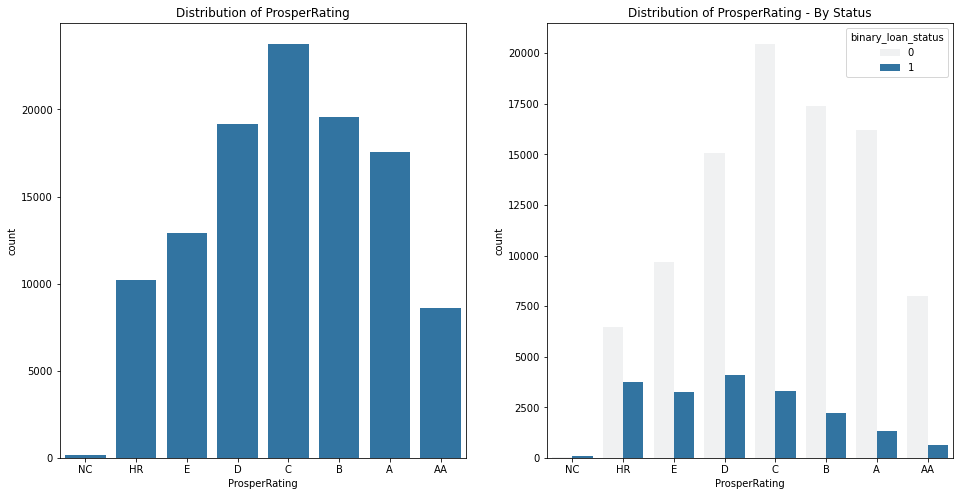

In [42]:
plot_countplots('ProsperRating')

In [43]:
stats_by_rating = stats_df('ProsperRating')
stats_by_rating

,Percentage of Total Loans,Percentage of Negative Loans,Percentage of Overall Negative Loans
NC,0.124164,70.503597,0.524991
HR,9.130944,36.881237,20.196068
E,11.532037,25.197521,17.426475
D,17.132802,21.334724,21.921037
C,21.238242,13.887954,17.688970
B,17.487427,11.232569,11.780147
A,15.662489,7.590966,7.130230
AA,7.691895,7.223319,3.332083


In [44]:
print('Total % of Loans D rating or Lower: ', stats_by_rating.iloc[:4,0].sum(), '\n' + 'Total % of Negative Loans D rating or Lower: ', stats_by_rating.iloc[:4,2].sum())

Total % of Loans D rating or Lower:  37.919945689555064 
Total % of Negative Loans D rating or Lower:  60.068570204103494


In [45]:
anova('ProsperRating')

F_onewayResult(statistic=971.8435895957566, pvalue=0.0)

The credit rating follows a symmetrical distribution, with most borrowers having a C rating. However, an expected trend appears when exploring the proportion of negative loan status within each rating. As a borrower's rating decreases, a more significant proportion of the loans fall into the negative status. At the most common rating, 'C,' around 14% of the loans were in a negative status. As the rating decreases, a borrower is more likely to be in a negative status. Borrowers with lower than C ratings made up 38% of the total loans; however, they were responsible for over 60% of the total loans in the negative status. The borrowers in these ratings have at least a 20% chance of missing a payment; the HR category is easier risky as more than one out of three borrowers is in a negative status.

The ANOVA test returned an F-Statistic of 971, showing a significantly higher squared sum than the squared sum within. Thus, leading to a P-Value of 0.0, rejecting the null hypothesis. This result shows that there is a statistically significant difference between the different credit ratings.

#### Borrower's APR

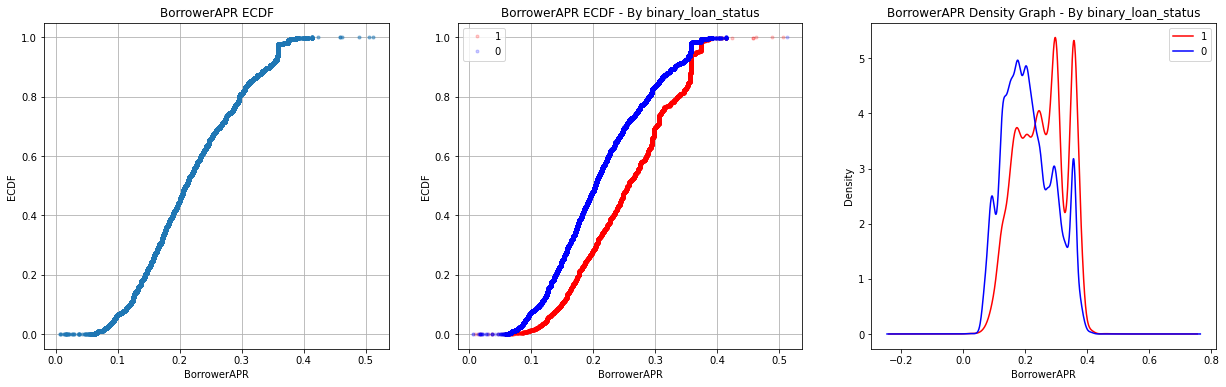

In [46]:
plot_ecdf_kde('BorrowerAPR')

In [47]:
print(diff_means('BorrowerAPR'))
print(t_test('BorrowerAPR'))

0.04203860389420336
Ttest_indResult(statistic=66.60662515172315, pvalue=0.0)


In this data, most borrowers had an APR of between 0.1 and 0.4 percent. In addition, the ECDF showed a similar trend; almost all the borrowers had an APR lower than 0.4. A jump occurs at around 0.35%; this signifies that a portion of the borrowers is clustered at this rate. There is a significant distinction between the two distributions when separated by the loan status. The negative loan status borrowers generally have about a 0.042 higher APR when compared to the other group. The distribution shows that 80% of the borrowers have less than 0.3 APR; this rate is around 0.35 for the same proportion for the group in a negative status. Furthermore, the KDE graph shows distinct differences between the two groups. Finally, the P-Value between the two groups is 0.000, signifying a statistically significant difference.

#### Debt to Income Ratio (DTI)

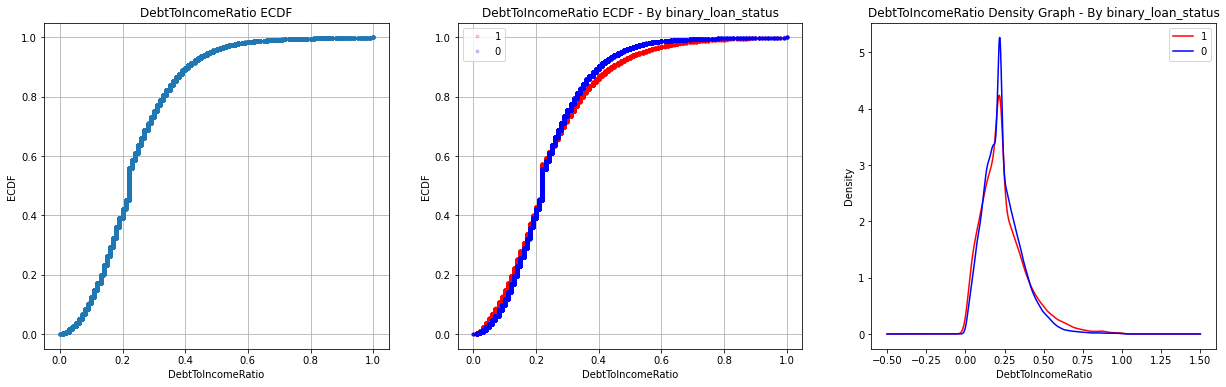

In [48]:
plot_ecdf_kde('DebtToIncomeRatio')

In [49]:
print(diff_means('DebtToIncomeRatio'))
print(t_test('DebtToIncomeRatio'))

0.007490252695151939
Ttest_indResult(statistic=7.164545706824237, pvalue=7.85232105054303e-13)


The borrower's DTI ratio distribution is right-skewed; around 90% of borrowers are below the industry standard of 0.40 DTI. When comparing the two groups, there is around a 0.008 difference in the borrower's DTI ratio average. In addition, the ECDF shows the two distributions are very similar up to the 60th percentile; above that, a higher proportion of the borrowers in the negative status group has a higher DTI ratio. This trend is also apparent in the density graph; the borrowers in the positive status group have a higher concentration at a 0.25 DTI ratio. In comparison, the negative status group has a higher proportion of borrowers with a higher than 0.50 DTI ratio. Lastly, the p-value when comparing the distributions of this feature when separated by the loan status is 0.000, signifying a statistically significant difference.

#### Loan Original Amount

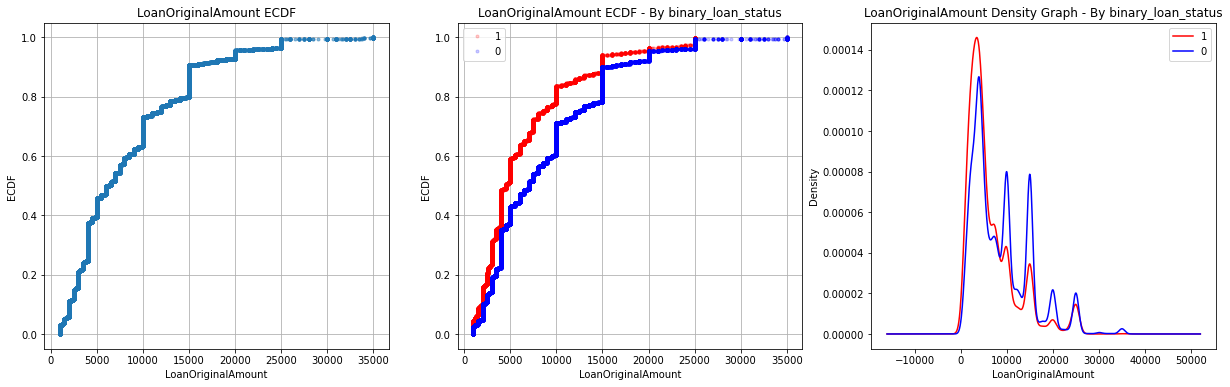

In [50]:
plot_ecdf_kde('LoanOriginalAmount')

In [51]:
print(diff_means('LoanOriginalAmount'))
print(t_test('LoanOriginalAmount'))

-2068.5183379463433
Ttest_indResult(statistic=-42.11377688206851, pvalue=0.0)


The loan amount ranges from 1,000 to 35,000 USD, with 80% of the loans below 15,000. There are jumps in the ECDF graph at every 5,000 interval; this makes sense as people are likely to borrow an even amount. When comparing this distribution separated by the loan status, it is evident that the loans that fell into the negative status were generally smaller. Over 80% of the loans in the negative status were less than 10,000. In comparison, 80% of the loan in the positive status group were less than 15,000; the average loan size was 2,117 greater. The KDE plot shows a similar trend, the negative group has a density under 10,000 while the positive group multiple peaks at each 5,000 increments. Lastly, the T-test returned a P-Value of 0.000, signifying a statistically significant difference between the two group's distributions.

#### Loan Term

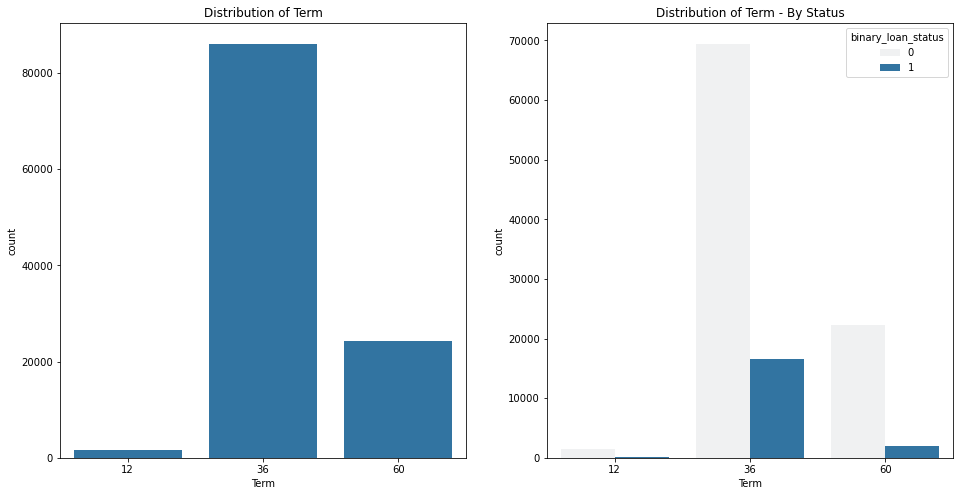

In [52]:
plot_countplots('Term')

In [53]:
stats_df('Term')

,Percentage of Total Loans,Percentage of Negative Loans,Percentage of Overall Negative Loans
12,1.415823,5.741325,0.487491
36,76.919847,19.336670,89.200193
60,21.664329,7.937162,10.312316


In [54]:
anova('Term')

F_onewayResult(statistic=970.6047061653381, pvalue=0.0)

The 36-month loan term is the most popular with borrowers, accounting for over 76% of the total; the 60-month term makes up 22% of the distribution. The remaining ~2% is the 12-month term. When examining the proportion of loans in negative status, 18% of the loans in the 36-month term falls into this category. Only 10% of the 60-month term loans are in this status. Over 89% of all the loans in negative status are in the 36-month term, a 12% increase in the weighted proportions. In addition, the ANOVA test resulted in a p-value of 0.0, thus rejecting the null hypothesis.

#### Monthly Income

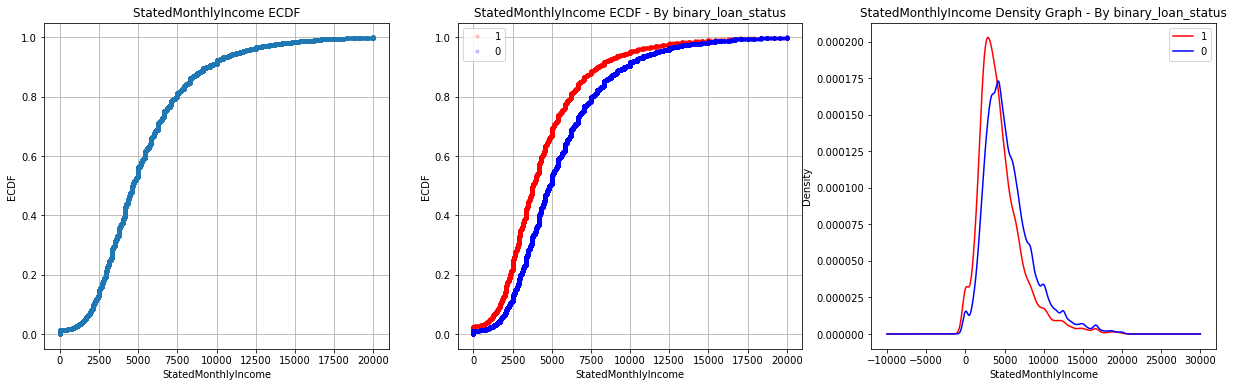

In [55]:
plot_ecdf_kde('StatedMonthlyIncome')

In [56]:
print(diff_means('StatedMonthlyIncome'))
print(t_test('StatedMonthlyIncome'))

-1071.9300338956236
Ttest_indResult(statistic=-43.30200460688765, pvalue=0.0)


The graphs for the stated monthly income variable show that roughly 90% of the borrowers reported less than 10,000 monthly income. The difference is apparent when separated by the loan status; the borrowers in the negative status reported 1071 dollars lower on average. The density graph shows that the borrowers in the negative loan status have a strong concentration below 10000 per month. The positive group has a less concentrated distribution and has a higher proportion of borrowers with higher income. The T-test returned a P-Value of 0, which rejects the null hypothesis.

#### Credit Lines Open

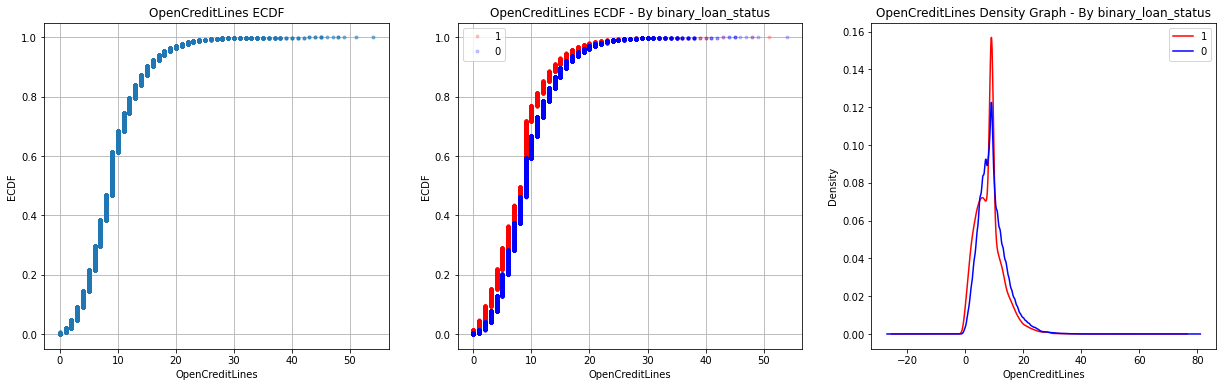

In [57]:
plot_ecdf_kde('OpenCreditLines')

In [58]:
print('Difference in average opened credit lines: ', diff_means('OpenCreditLines'))

Difference in average opened credit lines:  -1.1382856913970034


In [59]:
print(t_test('OpenCreditLines'))

Ttest_indResult(statistic=-29.541105730103187, pvalue=4.657095876451407e-191)


The open credit lines feature showed that over 90% of borrowers had less than twenty lines opened. When separated by the status, the borrowers in the negative status have fewer lines opened by an average of 1.2. The T-Test also resulted in a P-Value lower than the alpha, thus rejecting the null hypothesis.

#### Income Verifiable

In [60]:
stats_df('IncomeVerifiable')

,Percentage of Total Loans,Percentage of Negative Loans,Percentage of Overall Negative Loans
False,7.437315,19.517175,8.705202
True,92.562685,16.446156,91.294798


In [61]:
t_test('IncomeVerifiable')

Ttest_indResult(statistic=-7.234364237655461, pvalue=4.706928482821894e-13)

Over 92.5% of borrowers in this dataset were able to verify their income; 16.5% of this group fell into a negative status. In contrast, over 19.5% of the borrowers that couldn't verify their income fell into a negative status, a 3% increase. When comparing each group's make up of the total percentage of negative loans, the unverified group had a 1.25% higher chance of a negative status relative to their proportion. The T-test returned a p-value of 0, signifying statistical significant differences between the two groups.

#### Correlations

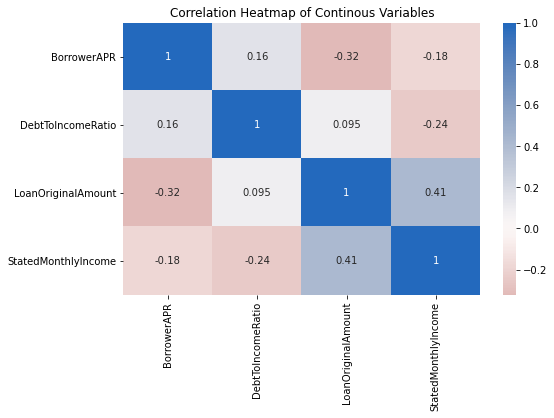

In [62]:
cont_vars = ['BorrowerAPR', 'DebtToIncomeRatio', 'LoanOriginalAmount', 'StatedMonthlyIncome']
df_cont = df[cont_vars]

plt.figure(figsize=(8,5))
sns.heatmap(df_cont.corr(), annot=True, cmap='vlag_r', center=0)
plt.title('Correlation Heatmap of Continous Variables')
plt.show()

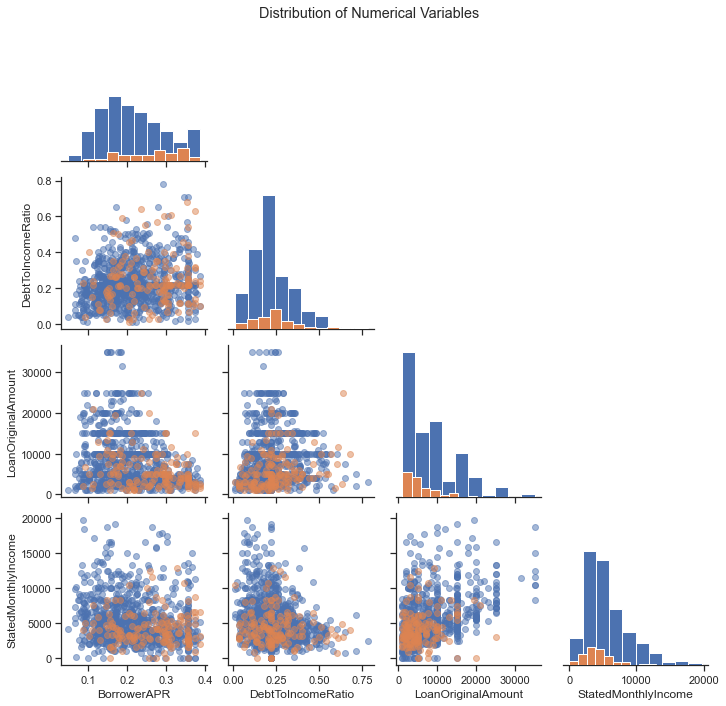

In [63]:
# sample a portion of data for clarity in graphs
samples = np.random.choice(df_cont.shape[0], 1000, replace=False)
df_cont_samples = df_cont.iloc[samples]

sns.set(style="ticks")
g = sns.PairGrid(data = df.iloc[samples], vars=cont_vars, hue='binary_loan_status', corner=True)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, alpha=0.5)
g.fig.suptitle('Distribution of Numerical Variables')
plt.show()

The numerical variables don't show a strong correlation; the only two variables with modest correlations are loan amount and stated monthly income, with a Pearson score of 0.41. A PairGrid was performed with 1000 random data points and colored by the different loan statuses to visualize trends between these variables. This graph further reinforces the findings from the bivariate analysis; the borrowers with loans in negative status generally have a lower loan amount and monthly income. However, they have higher APR on their loans. It is also interesting to note that there isn't a strong negative relationship between monthly income and DTI ratio; the common intuition is that the percentage of debt should be lower as income goes higher. Another interesting trend is the lack of correlation between the DTI ratio and the loan amount. DTI ratio is one of the primary metrics that lenders use to judge the borrower's ability to repay. Lastly, most loans with greater than 30% APR are below 10,000, and the loan amount has a negative trend with the borrower's APR.

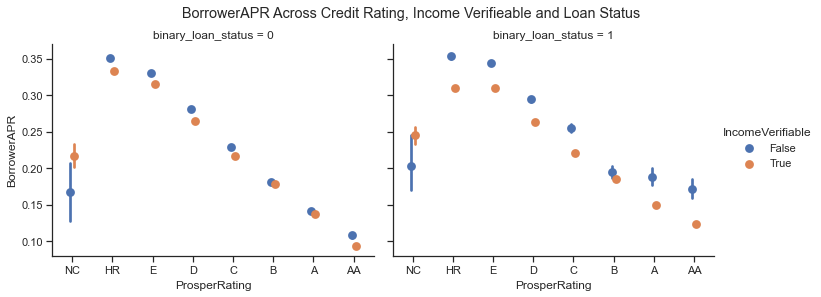

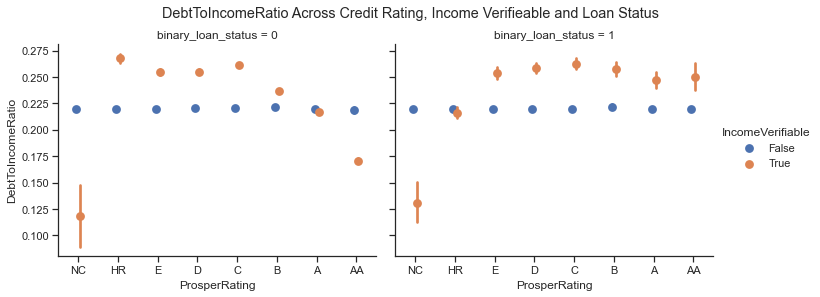

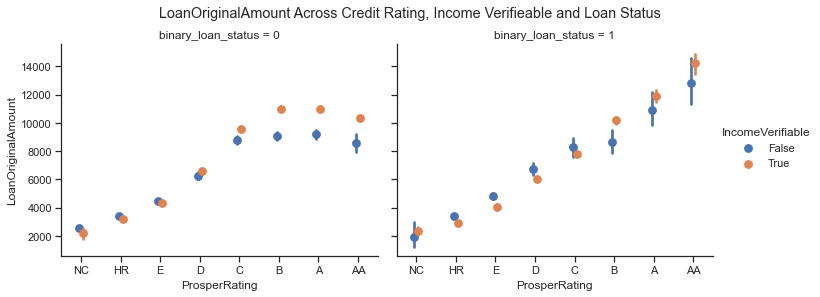

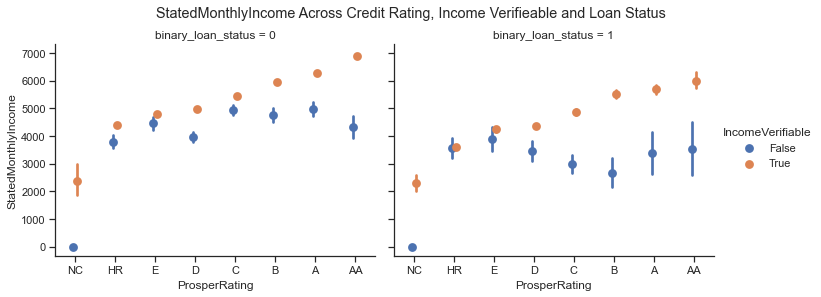

In [64]:
for i in range(len(cont_vars)):
    g = sns.catplot(x='ProsperRating', y=cont_vars[i], hue='IncomeVerifiable',
                  col='binary_loan_status', data=df, kind='point', linestyles='',
                  dodge=0.1, height=4, aspect=1.25)
    g.fig.suptitle('{} Across Credit Rating, Income Verifieable and Loan Status'.format(cont_vars[i]))
    g.fig.subplots_adjust(top=0.85)
plt.show()

When comparing all the categorical variables to each continuous variable, interesting trends appear. For example, in the case of a borrower's APR, there is a linear decrease as the credit rating increases. This trend makes sense as borrowers deemed more trustworthy pose less risk to the lender. However, there are discrepancies for the borrowers with no credit. First, they received rates in the same range as borrowers with a B or C rating. Second, borrowers in this rating who couldn't verify their income received lower rates than those who did. 
 
The DTI ratio graph shows that this metric trends downwards in the group that has their loans in a positive status. This trend is not true in the other group, as it trends up and stays flat across the ratings. Interestingly, all of their DTI ratios are the same across credit ratings and both groups for borrowers with income that couldn't be verified. This discrepancy needs to be further investigated, as this metric is one of the primary ways to gauge a borrower's ability to repay the loan.

The loan amount shows a similar trend between borrowers from NC -> C rating. However, the distribution stays relatively flat in the group with a positive status. The borrowers that were able to verify their income averaged a higher loan amount. In contrast, the negative status loan group's average loan amount showed a linear increase from NC -> AA. Furthermore, the two-income verifiable groups were very similar in the average loan amount.

The stated monthly income feature shows distinct differences between the two income verifiable groups. For example, the borrowers whose income was verified had a general increase as their credit ratings increased; this trend is true in both loan status groups. In contrast, the borrowers that couldn't verify their income didn't show the same increase as the ratings. Instead, they averaged between 4 to 5000 USD in the positive status category. Furthermore, borrowers with a B credit rating averaged the lowest stated monthly income in all categories besides those with no credit. 

## Analysis Summary

- All variables were statistically significantly different when comparing the two loan status groups.
- 16.67% of loans are in negative status (late payment, default, or charged-off).
- Borrowers with lower than a C rating made up 38% of loans but 60% of total negative loans.
- There is around a 4% difference in APR when comparing the two loan statuses.
- Borrowers in the positive status are concentrated around 20% APR, while the other group has two peaks around 35%.
 - On average, Loans in negative status were around 2000 USD less than their counterpart; more than 80% of loans in this status were less than 10,000.
- Over 75% of loans were the 36-month term; however, it made up 89% of total loans in a negative status.
- 60-month terms only made up 21% of loans; however, this term only 10.3% of total negative loans. This term poses less risk for the organization.
- Borrowers in the negative status made around 1000USD less than the positive status.
- Borrowers in the negative status had one less credit line on average than the other group.
- Borrowers that couldn't verify their income have a 3.1% higher chance of being in a negative status.
- No strong correlation between the numeric variables and some positive correlation between loan amount and income.
- A slight negative correlation between APR and loan amount, meaning lower rates for bigger loans.
- Majority of the high-interest loans (>30% APR) are 10,000 or less.


## Discrepancies

- All borrowers that didn't verify income have the same DTI ratio.
- NC credit rating has lower than expected APR despite having the highest proportion of defaults.

## Modeling

This project utilizes the extreme gradient boost (XGBoost) model to predict a borrower's loan status. Since this label is a binary variable, it is appropriate to use the classification method of this model. The metric used to measure the model performance is the 'ROC-AUC' score; this metric is more suitable compared to accuracy score due to the imbalance of the proportion of the loan statuses. 

The XGBoost model utilizes an ensemble of decision trees to minimize the loss function. Boosting refers to a technique built by each ensemble tree with the weak learner(s). By combining the different weak learners, this model converts them into strong ones and, at the same time, reduces bias and variance in the model. Next, this model utilizes the second order of the Taylor polynomial combined with regularization to calculate the output of each leaf. Lastly, the prediction is updated by adding the previous prediction by the output multiplied by the learning rate.

XGBoost utilizes a "Basic Exact Greedy" algorithm to determine the split of each tree node; the value to quantify this is called "Gain."  This algorithm starts with a single leaf and recursively adds branches by finding the maximum gain of each split. For the first iteration of the model, the initial prediction is made by initiating a constant value. Then, the gain is calculated by first calculating the weight of each leaf and the parent node. The weight is calculated by dividing the sum of the first-order derivative of the loss function(gradient) squared by the sum of the second-order derivative of the loss function(hessian) plus the lambda. This process is repeated until the maximum number of depths or if the minimum child weight is reached. Then, this model prunes each tree by subtracting the hyperparameter gamma from the gain of the lowest branch. If this formula results in a negative number, this branch will be pruned, and this step is repeated. However, if the lowest branch is not pruned, the model will not prune the parent branches if their gain - gamma is negative.

Finally, each leaf's output(weights) is calculated by approximating the loss function using the second-order polynomial plus regularization. If the  $\lambda$ is set to 0, this model's object is the same as traditional gradient boosting. The prediction is updated by adding the previous prediction plus the learning rate multiplied by the leaf output. These steps conclude the one iteration of the model. The model will repeat these iterations until the maximum number of iterations or the early stopping rounds is reached.

Initialize model with a constant value: $f_{0}(x) = \textrm{arg min}_{\hat{y}} \sum \limits _{i=1} ^{N} L(y_{i}, \hat{y})$

Find the first and second order derivate of the Loss Function: $g_i = ∂\hat{y} (t−1) l(y_i, \hat{y}^{(t−1)})$ and $h_i = ∂^2 \hat{y}(t−1) l(y_i, \hat{y}^{(t−1)})$

Determine the split point by maximizing the gain: $L_{split} = \frac{1}{2}[\frac{(\sum_{i \in IL} g_i)^{2}}{\sum_{i \in IL} h_i + \lambda} + \frac{(\sum_{i \in IR} g_i)^{2}}{\sum_{i \in IR} h_i + \lambda} - \frac{(\sum_{i \in I} g_i)^{2}}{\sum_{i \in I} h_i + \lambda}] - \gamma$

###### - This step is repeated until the minimum child weight or the maximum depth is reached
###### - If the gain - $\gamma$ of the lowest branch is negative, this branch will be pruned and repeated for the parent branches. However, if this branch isn't pruned, the parent branch will not be pruned even if this is negative.

Once the tree is completed, the output(weight) value of each leaf is approximated with the second order of Taylor Polynomials, simplified to: $w_{j} = -\frac{\sum_{i \in I_{j}} g_i}{\sum_{i \in I_{j}} h_i + \lambda}$ 

The prediction is updated by adding the previous prediction plus the learning rate multiplied by the new output: $\hat{y}_{i}^{(t−1)} + \eta w_{i}^{t}$

### Model Limitations


In [65]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

#### Encoding Categorical Columns

In [66]:
# encode categorical columns with dummy columns
df_encoded = pd.get_dummies(df, columns=['IncomeVerifiable', 'ProsperRating'])
df_encoded.drop(columns=['LoanStatus'], inplace=True)
print(df_encoded.head())

   Term  BorrowerAPR  DebtToIncomeRatio  LoanOriginalAmount  \
0    36      0.16516               0.17                9425   
1    36      0.12016               0.18               10000   
2    36      0.28269               0.06                3001   
3    36      0.12528               0.15               10000   
4    36      0.24614               0.26               15000   

   StatedMonthlyIncome  OpenCreditLines  binary_loan_status  \
0          3083.333333                4                   0   
1          6125.000000               14                   0   
2          2083.333333                9                   0   
3          2875.000000                5                   0   
4          9583.333333               19                   0   

   IncomeVerifiable_False  IncomeVerifiable_True  ProsperRating_NC  \
0                       0                      1                 0   
1                       0                      1                 0   
2                       0       

In [67]:
features = df_encoded.drop(columns='binary_loan_status').columns
labels = 'binary_loan_status'

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features], df_encoded[labels], stratify=df_encoded[labels],
                                                        test_size=0.3)

#### Initial Model

In [69]:
# build model with default hyper parameters

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=123, eval_metric='auc')
clf_xgb.fit(X_train, y_train, verbose=True,         
           eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-auc:0.72455	validation_1-auc:0.71722
[1]	validation_0-auc:0.73974	validation_1-auc:0.73057
[2]	validation_0-auc:0.75868	validation_1-auc:0.74976
[3]	validation_0-auc:0.76495	validation_1-auc:0.75640
[4]	validation_0-auc:0.77087	validation_1-auc:0.76226
[5]	validation_0-auc:0.77549	validation_1-auc:0.76525
[6]	validation_0-auc:0.78167	validation_1-auc:0.77170
[7]	validation_0-auc:0.78556	validation_1-auc:0.77370
[8]	validation_0-auc:0.78814	validation_1-auc:0.77611
[9]	validation_0-auc:0.79044	validation_1-auc:0.77841
[10]	validation_0-auc:0.79237	validation_1-auc:0.77964
[11]	validation_0-auc:0.79372	validation_1-auc:0.78029
[12]	validation_0-auc:0.79561	validation_1-auc:0.78081
[13]	validation_0-auc:0.79669	validation_1-auc:0.78151
[14]	validation_0-auc:0.79732	validation_1-auc:0.78217
[15]	validation_0-auc:0.79867	validation_1-auc:0.78250
[16]	validation_0-auc:0.79912	validation_1-auc:0.78278
[17]	validation_0-auc:0.79984	validation_1-auc:0.78318
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

In [70]:
param_grid = {'max_depth':np.arange(2,12),
             'colsample_bytree': np.arange(0.3,0.6,0.1),
             'learning_rate':[0.01,0.05,0.1],
             'gamma':[0, 0.05, 0.1, 0.25],
             'reg_lambda':[0,1,2],
             'n_estimators':[100,200,300,600],
             'subsample':[0.25,0.5,0.75,1]}

In [71]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=123)
randomized_auc = RandomizedSearchCV(estimator=clf_xgb, param_distributions=param_grid,
                                   scoring='roc_auc', n_iter=3, cv=10, verbose=1)

In [72]:
randomized_auc.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, r

In [73]:
randomized_auc.best_params_

{'subsample': 0.5,
 'reg_lambda': 1,
 'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [74]:
randomized_auc.best_score_

0.7897989561883926

In [79]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=345,
                           eval_metric='auc',
                           subsample=0.25,
                           reg_lambda=2,
                           n_estimators=300,
                           max_depth=4,
                           learning_rate=0.1,
                           gamma=0.05, colsample_bytree=0.5, early_stopping_rounds = 50)
clf_xgb.fit(X_train, y_train,
           verbose=True,
           eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-auc:0.64700	validation_1-auc:0.64453
[1]	validation_0-auc:0.69612	validation_1-auc:0.69321
[2]	validation_0-auc:0.70346	validation_1-auc:0.69944
[3]	validation_0-auc:0.70956	validation_1-auc:0.70520
[4]	validation_0-auc:0.71094	validation_1-auc:0.70621
[5]	validation_0-auc:0.71525	validation_1-auc:0.70900
[6]	validation_0-auc:0.71815	validation_1-auc:0.71132
[7]	validation_0-auc:0.72417	validation_1-auc:0.71714
[8]	validation_0-auc:0.72681	validation_1-auc:0.71972
[9]	validation_0-auc:0.72709	validation_1-auc:0.71962
[10]	validation_0-auc:0.72736	validation_1-auc:0.71996
[11]	validation_0-auc:0.72857	validation_1-auc:0.72094
[12]	validation_0-auc:0.72821	validation_1-auc:0.72045
[13]	validation_0-auc:0.72974	validation_1-auc:0.72259
[14]	validation_0-auc:0.73106	validation_1-auc:0.72375
[15]	validation_0-auc:0.73155	validation_1-auc:0.72407
[16]	validation_0-auc:0.73422	validation_1-auc:0.72721
[17]	validation_0-auc:0.73786	validation_1-auc:0.73093
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='auc', gamma=0.05, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=345,
              reg_alpha=0, reg_lambda=2, ...)

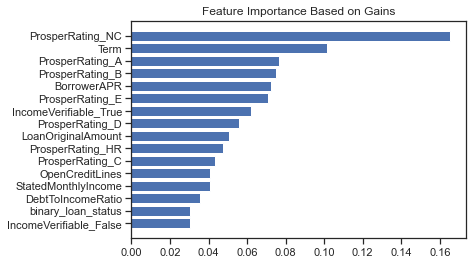

In [76]:
sort_idx = clf_xgb.feature_importances_.argsort()
plt.barh(df_encoded.columns[sort_idx], clf_xgb.feature_importances_[sort_idx])
plt.title('Feature Importance Based on Gains')
plt.show()

In [80]:
y_pred = clf_xgb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[27534,   451],
       [ 4831,   769]], dtype=int64)

In [81]:
accuracy_score(y_test, y_pred)

0.8427274080690784

In [82]:
# Saving Model
clf_xgb.save_model('loan_default_xgbmodel.json')

## Model Evaluation and Next Steps



The initial model resulted in an AUC score of 0.86 on the training data and 0.79 on the testing data, signifying the overfitting of the model. Next, I utilized the RandomizedSearchCV function from the sci-kit learn library to tune the various hyperparameter of the model. This method randomly selects hyperparameters from the input grid to test the selected metric through cross-validation. Since this method doesn't try every input from the parameter, it is faster than its counterpart GridSearchCV. However, the trade-off is that it might not find the most optimal set of parameters due to the randomness of the search method. After tuning the hyperparameter, the model resulted in an AUC score of 0.81 on the training set and 0.78 on the testing set. Even though the AUC score on the test result decreased by 0.01, the AUC score on the training set decreased by 0.05, thus a better-generalized model. 

The limitation of XGBoost models is the interpretability of the features. Unlike a basic decision tree with only one tree, XGBoost utilizes hundreds, if not thousands, of trees to optimize the prediction. So it's much more challenging to quantify the feature's importance. Therefore, I ordered them by how much "Gain" resulted from splitting each feature in this analysis. The resulting feature importance is shown in the horizontal bar graph above.

#### Next Steps

It is important to note that due to both time and hardware constraints, I only selected nine features to perform exploratory data analysis and modeling. XGBoost is designed to be utilized with a large number of features to take full advantage of its boosting and regularization properties. I will keep updating this analysis to include more features in the future. I believe that using all 81 features in this dataset will result in a much more accurate model.